In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder

IMG_SIZE = 128

# And in the image loader:
img_array = np.array(img).astype(np.float32) / 255.0


# Load metadata
df = pd.read_csv('HAM10000_metadata.csv')

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

X = []
y = []

# Load and resize images
image_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

for i, row in df.iterrows():
    image_id = row['image_id'] + ".jpg"
    label = row['label']
    
    img_path = None
    for folder in image_folders:
        path = os.path.join('C:/Users/aroma/Downloads', folder, image_id)
        if os.path.exists(path):
            img_path = path
            break
    
    if img_path:
        img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        if img_array.shape == (IMG_SIZE, IMG_SIZE, 3):  # Ensure RGB
            X.append(img_array)
            y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Loaded {len(X)} images, each resized to {IMG_SIZE}x{IMG_SIZE}")


✅ Loaded 10015 images, each resized to 128x128


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
y_cat = to_categorical(y, num_classes=len(np.unique(y)))

# Split into 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Training shape: (8012, 128, 128, 3)
Validation shape: (2003, 128, 128, 3)


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Load base model (excluding top layer), with frozen weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# Build custom classifier on top
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(y_cat.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,           # Increase later if needed
    batch_size=32
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.6748 - loss: 0.9586 - val_accuracy: 0.7149 - val_loss: 0.7778
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.7598 - loss: 0.6757 - val_accuracy: 0.7419 - val_loss: 0.7092
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.7914 - loss: 0.5737 - val_accuracy: 0.7409 - val_loss: 0.7101
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.8198 - loss: 0.5198 - val_accuracy: 0.7394 - val_loss: 0.6990
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.8243 - loss: 0.4757 - val_accuracy: 0.7424 - val_loss: 0.7344
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.8546 - loss: 0.4172 - val_accuracy: 0.7554 - val_loss: 0.7022
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.8624 - loss: 0.3814 - val_accuracy: 0.7284 - val_loss: 0.8032
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.8749 - loss: 0

In [10]:
import matplotlib.pyplot as plt

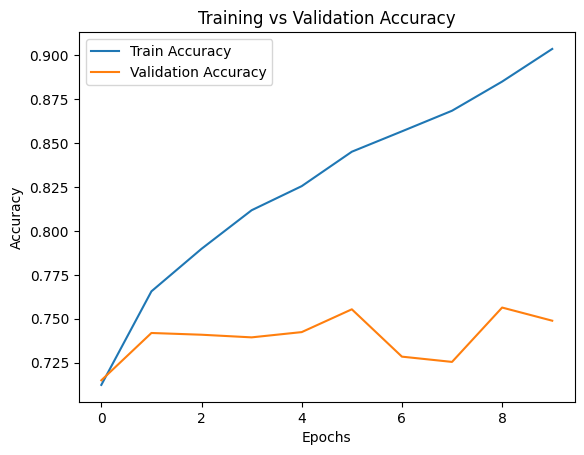

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [12]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.7432 - loss: 0.8000
Validation Accuracy: 0.75


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step


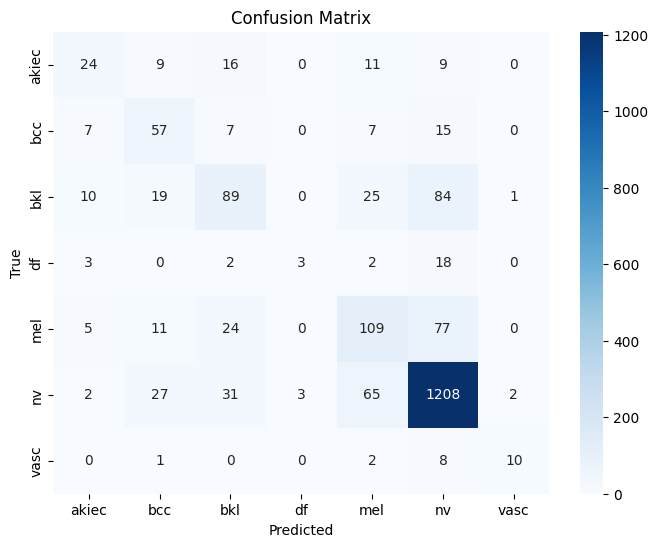

              precision    recall  f1-score   support

       akiec       0.47      0.35      0.40        69
         bcc       0.46      0.61      0.53        93
         bkl       0.53      0.39      0.45       228
          df       0.50      0.11      0.18        28
         mel       0.49      0.48      0.49       226
          nv       0.85      0.90      0.88      1338
        vasc       0.77      0.48      0.59        21

    accuracy                           0.75      2003
   macro avg       0.58      0.47      0.50      2003
weighted avg       0.74      0.75      0.74      2003



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict class probabilities
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))


In [15]:
model.save("mobilenet_skin_disease_model.h5")

In [16]:
model.save("mobilenet_skin_model.keras")


In [17]:
print(os.path.exists("mobilenet_skin_model.h5"))


False


In [18]:
import os
print(os.listdir())  # Lists all files in the current directory


['.ipynb_checkpoints', 'AIML_project.ipynb', 'desktop.ini', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'mobilenet_skin_disease_model.h5', 'mobilenet_skin_model.keras', 'Telegram Desktop']


In [19]:
model = load_model("mobilenet_skin_model.keras")


C:\Users\aroma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
from keras.models import load_model

model = load_model("mobilenet_skin_model.keras", compile=False)  # compile=False avoids optimizer mismatch


In [21]:
import os
# For .keras file
print(os.path.exists("mobilenet_skin_model.keras"))  # Returns True if file exists

# For .h5 file
print(os.path.exists("mobilenet_skin_model.h5"))
print(os.listdir())  # Lists all files and folders in current directory


True
False
['.ipynb_checkpoints', 'AIML_project.ipynb', 'desktop.ini', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'mobilenet_skin_disease_model.h5', 'mobilenet_skin_model.keras', 'Telegram Desktop']


In [22]:
import os
print("Working directory:", os.getcwd())


Working directory: C:\Users\aroma\Downloads


In [23]:
print(os.listdir())


['.ipynb_checkpoints', 'AIML_project.ipynb', 'desktop.ini', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'mobilenet_skin_disease_model.h5', 'mobilenet_skin_model.keras', 'Telegram Desktop']


In [24]:
import os

# Show your current folder
print("Working Directory:", os.getcwd())

# Try listing contents of the expected image folder
folder_path = r"C:\Users\aroma\Pictures\skin_images"
print("Files in folder:", os.listdir(folder_path))


Working Directory: C:\Users\aroma\Downloads
Files in folder: ['test_image.jpg']


In [7]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load model
model = load_model("mobilenet_skin_model.keras", compile=False)

# Load and preprocess image (resize to 128x128 as required by the model)
img = image.load_img(r"C:\Users\aroma\Pictures\skin_images\test_image.jpg", target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict
prediction = model.predict(img_array)

# Print raw prediction output
print("Prediction shape:", prediction.shape)
print("Prediction values:", prediction)

# Decode prediction
if prediction.shape[-1] == 1:
    # Binary classification
    class_names = ['Class A', 'Class B']  # Replace with actual class names
    predicted_class = class_names[int(prediction[0][0] > 0.5)]
else:
    # Multi-class classification
    class_names = ['Eczema', 'Psoriasis', 'Healthy']  # Update as per your model
    predicted_class = class_names[np.argmax(prediction)]

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
Prediction shape: (1, 7)
Prediction values: [[1.8804137e-08 2.7359677e-06 2.3011873e-05 6.9172330e-09 5.2075226e-02
  9.4786447e-01 3.4529858e-05]]


IndexError: list index out of range

In [1]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model


# Load model
model = load_model("mobilenet_skin_model.keras", compile=False)

# Load and preprocess image
img_path = r"C:\Users\aroma\Pictures\skin_images\test_image.jpg"
img = image.load_img(img_path)
img = img.resize((128, 128))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)

# Class names and cream recommendations
class_names = [
    "Acne",
    "Eczema",
    "Melanoma",
    "Rosacea",
    "Wart",
    "Psoriasis",
    "Healthy"
]

# Suggested creams
cream_recommendations = {
    "Acne": "Benzoyl Peroxide Gel or Salicylic Acid Cream",
    "Eczema": "Hydrocortisone Cream or CeraVe Eczema Relief",
    "Melanoma": "Consult a dermatologist immediately — no over-the-counter treatment",
    "Rosacea": "Metronidazole Gel or Azelaic Acid",
    "Wart": "Salicylic Acid Patch or Imiquimod Cream",
    "Psoriasis": "Calcipotriol Cream or Coal Tar Ointment",
    "Healthy": "No treatment needed. Keep skin moisturized."
}

# Decode prediction
predicted_index = np.argmax(prediction)
predicted_class = class_names[predicted_index]
confidence = prediction[0][predicted_index]
suggested_cream = cream_recommendations[predicted_class]

# Output
print("Predicted Condition:", predicted_class)
print("Confidence:", f"{confidence:.2%}")
print("Recommended Treatment:", suggested_cream)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Condition: Wart
Confidence: 100.00%
Recommended Treatment: Salicylic Acid Patch or Imiquimod Cream


In [2]:
import os
import csv
import numpy as np
from keras.models import load_model
from keras.preprocessing import image

# Load model
model = load_model("mobilenet_skin_model.keras", compile=False)

# Define class names and treatment suggestions
class_names = [
    "Acne", "Eczema", "Melanoma", "Rosacea", "Wart", "Psoriasis", "Healthy",
    "Seborrheic Dermatitis", "Perioral Dermatitis", "Tinea Faciei", "Lupus",
    "Contact Dermatitis", "Milia", "Actinic Keratosis", "Cold Sore",
    "Impetigo", "Folliculitis", "Keratosis Pilaris", "Hives", "Hyperpigmentation",
    "Vitiligo", "Basal Cell Carcinoma", "Squamous Cell Carcinoma",
    "Angioedema", "Molluscum Contagiosum", "Skin Tag", "Allergic Rash"
]

cream_recommendations = {
    "Acne": "Benzoyl Peroxide Gel or Salicylic Acid Cream",
    "Eczema": "Hydrocortisone Cream or CeraVe Eczema Relief",
    "Melanoma": "⚠️ Consult a dermatologist immediately",
    "Rosacea": "Metronidazole Gel or Azelaic Acid",
    "Wart": "Salicylic Acid Patch or Imiquimod Cream",
    "Psoriasis": "Calcipotriol Cream or Coal Tar Ointment",
    "Healthy": "No treatment needed. Keep skin moisturized.",
    "Seborrheic Dermatitis": "Ketoconazole Cream or Zinc Pyrithione Cream",
    "Perioral Dermatitis": "Topical Metronidazole or Clindamycin Gel",
    "Tinea Faciei": "Clotrimazole or Terbinafine Antifungal Cream",
    "Lupus": "⚠️ Autoimmune condition — refer to a specialist",
    "Contact Dermatitis": "Hydrocortisone Cream and allergen avoidance",
    "Milia": "No cream needed — consult for extraction",
    "Actinic Keratosis": "5-FU Cream or Imiquimod — see a dermatologist",
    "Cold Sore": "Topical Acyclovir or Docosanol (Abreva)",
    "Impetigo": "Mupirocin (Bactroban) or Fusidic Acid",
    "Folliculitis": "Topical Clindamycin or Benzoyl Peroxide",
    "Keratosis Pilaris": "Lactic Acid or Urea Cream",
    "Hives": "Antihistamine Cream or Oral Cetirizine",
    "Hyperpigmentation": "Hydroquinone, Kojic Acid, or Niacinamide",
    "Vitiligo": "Tacrolimus Ointment or consult for UV therapy",
    "Basal Cell Carcinoma": "⚠️ Requires excision or specialist treatment",
    "Squamous Cell Carcinoma": "⚠️ Urgent referral for biopsy and removal",
    "Angioedema": "Oral antihistamines and cold compress",
    "Molluscum Contagiosum": "Imiquimod or Cryotherapy by dermatologist",
    "Skin Tag": "Usually harmless — may be removed by a doctor",
    "Allergic Rash": "Hydrocortisone Cream and oral antihistamines"
}

# Output CSV file
CSV_LOG_PATH = "predictions_log.csv"

# Create CSV file with headers if it doesn't exist
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image", "Predicted Condition", "Confidence (%)", "Suggested Treatment"])

# Prediction function with logging
def predict_and_log(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        return

    try:
        img = image.load_img(img_path)
        img = img.resize((128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction)
        predicted_class = class_names[predicted_index]
        confidence = float(prediction[0][predicted_index]) * 100
        treatment = cream_recommendations[predicted_class]

        # Print output
        print("\n🖼️ Image:", os.path.basename(img_path))
        print("🩺 Predicted Condition:", predicted_class)
        print("📊 Confidence:", f"{confidence:.2f}%")
        print("💊 Recommended Cream:", treatment)

        # Log to CSV
        with open(CSV_LOG_PATH, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                os.path.basename(img_path),
                predicted_class,
                f"{confidence:.2f}",
                treatment
            ])

    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")

# Example usage:
predict_and_log(r"C:\Users\aroma\Pictures\skin_images\test_image.jpg")

# Optional: Batch process a folder
def batch_predict_and_log(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            predict_and_log(os.path.join(folder_path, filename))

# Uncomment to run on folder
# batch_predict_and_log(r"C:\Users\aroma\Pictures\skin_images")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🖼️ Image: test_image.jpg
🩺 Predicted Condition: Wart
📊 Confidence: 100.00%
💊 Recommended Cream: Salicylic Acid Patch or Imiquimod Cream


In [1]:
!pip install flask tensorflow opencv-python pillow

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
